# Predicting Causal SNPs

In [1]:
# You can get rid of whatever libraries you dont need

import sys
import os
import random
import numpy as np
from numba import jit, prange
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_undirected, negative_sampling
import networkx as nx
from scipy.spatial import cKDTree
from scipy.special import expit
from typing import List, Dict
import time
import cProfile
import pstats
import io
import category_encoders as ce
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import copy
from torch_geometric.transforms import RandomNodeSplit
from collections import Counter



# Print versions of imported libraries
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Torch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda")          # Current CUDA device
    print(f"Using {torch.cuda.get_device_name()} ({device})")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
NumPy version: 1.24.1
Pandas version: 1.5.3
Matplotlib version: 3.7.1
Scikit-learn version: 1.3.0
Torch version: 2.0.1+cu117
Torch Geometric version: 2.3.1
NetworkX version: 3.0
Using NVIDIA RTX A6000 (cuda)
CUDA version: 11.7
Number of CUDA devices: 2


## Spec

### Data Description

The dataset is a Pandas DataFrame named `data`, which includes the following columns:

- `id`: Unique ID of the variant in the format #chrom:pos:ref:alt (string).
- `#chrom`: Chromosome number where the genetic variant is located.
- `pos`: Position of the genetic variant on the chromosome (integer between 1 and 200,000).
- `ref`: Reference allele (or variant) at the genomic position.
- `alt`: Alternate allele observed at the genomic position.
- `rsids`: Reference SNP cluster ID, a unique identifier for each variant used in the dbSNP database.
- `nearest_genes`: Gene nearest to the variant (string).
- `pval`: P-value, a statistical measure for the strength of evidence against the null hypothesis.
- `mlogp`: Minus log of the p-value, commonly used in genomic studies.
- `beta`: Beta coefficient, representing the effect size of the variant.
- `sebeta`: Standard error of the beta coefficient.
- `af_alt`: Allele frequency of the alternate variant in the general population (float between 0 and 1).
- `af_alt_cases`: Allele frequency of the alternate variant in the cases group (float between 0 and 1).
- `af_alt_controls`: Allele frequency of the alternate variant in the control group (float between 0 and 1).
- `finemapped`: Indicator whether the variant is included in the post-finemapped subset (1) or not (0) (integer).
- `precausal`: Indicator whether the variant is included in the precausal subset (1) or not (0) (integer).
- `causal`: Indicator whether the variant is included in the causal subset (1) or not (0) (integer).
- `trait`: Trait associated with the variant. In this dataset, it refers to the response to the drug paracetamol and NSAIDs.

### Data Subset 
From least likely to be causal (left) to most likely to be causal (right):

GWAS (20 million SNPs) --> Finemapped (3 million SNPs) --> Precausal (1300 SNPs) --> Causal (21 SNPs)

### Task Overview

The task is to build a binary classifier that predicts whether a SNP is included in the causal dataset (i.e., `causal=1`).

### Resources 
- FinnGen Docs: https://finngen.gitbook.io/documentation/
- GWAS YouTube Video: https://www.youtube.com/watch?v=sOP8WacfBM8

## Data

In [2]:
dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'finemapped': 'int64',
    'precausal': 'int64',
    'causal': 'int64'
}

data = pd.read_csv('hyp-finemapped-precausal.csv', dtype=dtypes)

# Assert column names
expected_columns = ['#chrom', 'pos', 'ref', 'alt', 'rsids', 'nearest_genes', 'pval', 'mlogp', 'beta',
                    'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls',
                    'id', 'trait', 'precausal']
assert set(data.columns) == set(expected_columns), "Unexpected columns in the data DataFrame."

# Assert data types
expected_dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'precausal': 'int64'
}

for col, expected_dtype in expected_dtypes.items():
    assert data[col].dtype == expected_dtype, f"Unexpected data type for column {col}."

In [3]:
missing_values = data['nearest_genes'].isna().sum()
print(f"The number of missing values in 'nearest_genes' is: {missing_values}")

The number of missing values in 'nearest_genes' is: 134


In [4]:
# Remove rows where 'nearest_genes' is missing
data = data.dropna(subset=['nearest_genes'])

# Check the new shape of the DataFrame
print(f"The shape of the data after removing missing 'nearest_genes': {data.shape}")

The shape of the data after removing missing 'nearest_genes': (7363, 16)


In [5]:
precausal_sum = data['precausal'].sum()
print(f"The sum of 'precausal' is: {precausal_sum}")

The sum of 'precausal' is: 283


## PyGSP

In [6]:
import pandas as pd
import numpy as np
from pygsp import graphs
from scipy.sparse import dok_matrix

# Assuming data is a DataFrame that has been previously defined

# Initialize sparse adjacency matrix with zeros
adjacency = dok_matrix((data.shape[0], data.shape[0]), dtype=np.float32)

# Iterate over each chromosome
for chromosome, group in data.groupby('#chrom'):
    indices = group.index
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            # Calculate pos_diff_abs
            pos_diff_abs = abs(data.loc[indices[i], 'pos'] - data.loc[indices[j], 'pos'])
            
            # Calculate weight using given formula
            weight = 1 * np.exp(-np.log(2) / 100_000 * pos_diff_abs)
            
            # Update the adjacency matrix
            adjacency[indices[i], indices[j]] = weight
            adjacency[indices[j], indices[i]] = weight

# Create the graph using the adjacency matrix
G = graphs.Graph(adjacency.tocsr())

Error: smallest eigenvalue of the Laplacian is not close to zero


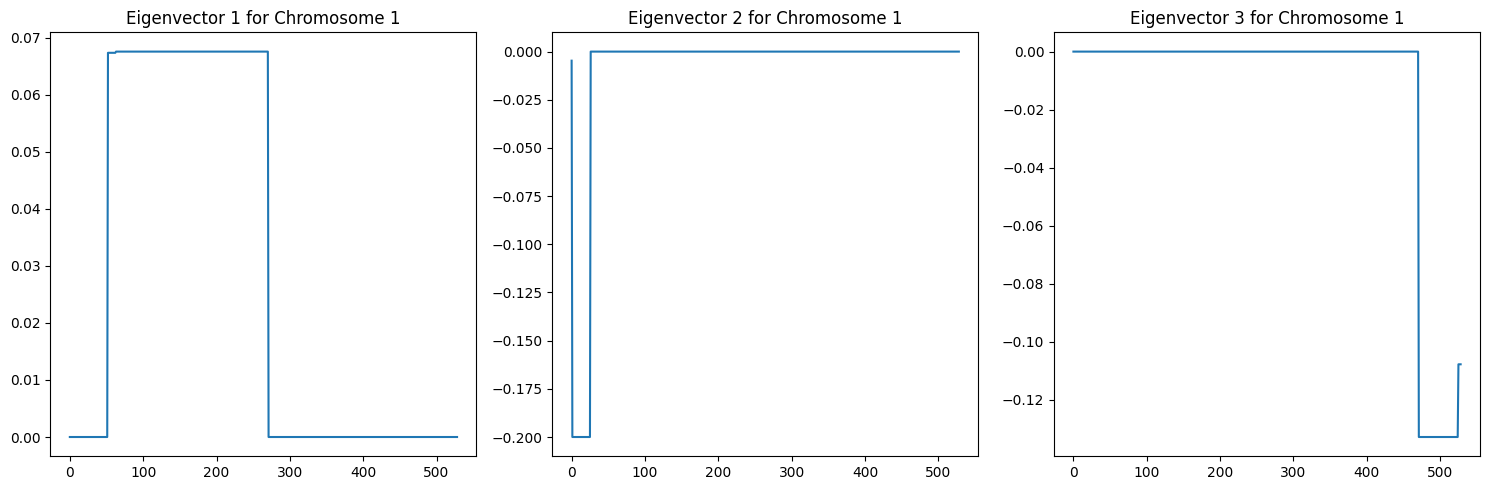

Error: smallest eigenvalue of the Laplacian is not close to zero


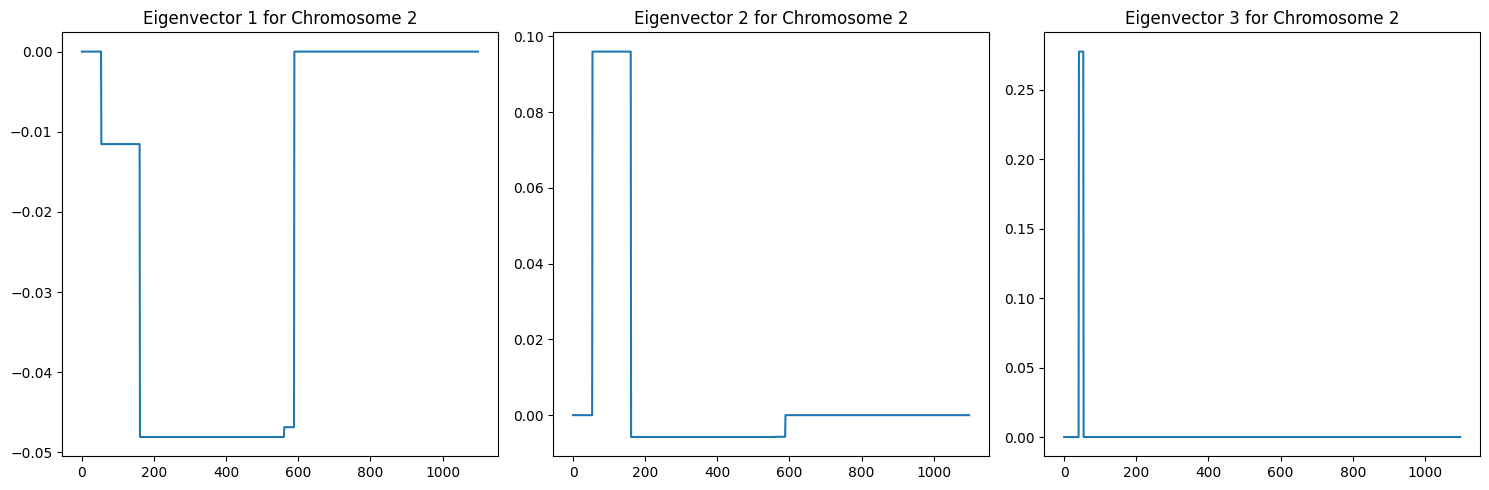

Error: smallest eigenvalue of the Laplacian is not close to zero


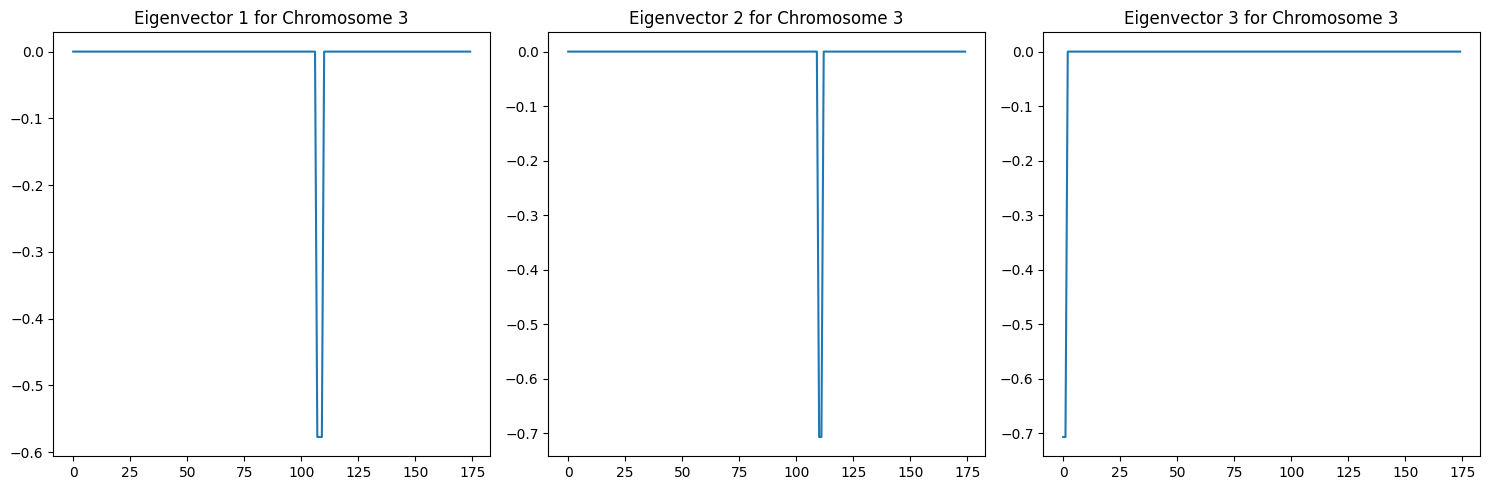

Error: smallest eigenvalue of the Laplacian is not close to zero


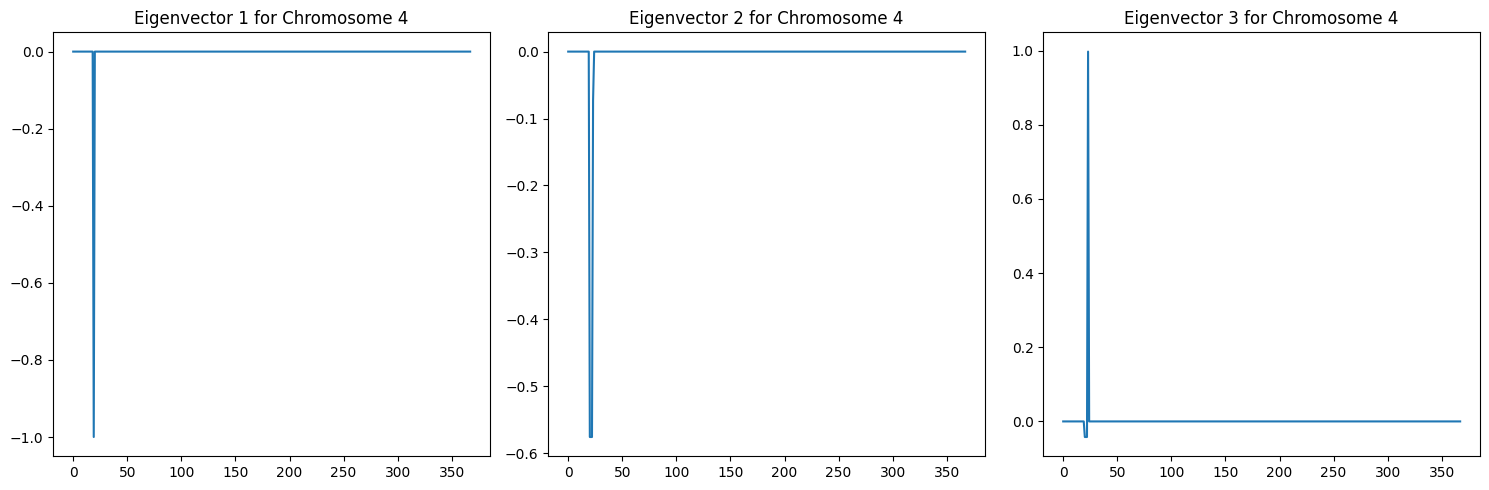

Error: smallest eigenvalue of the Laplacian is not close to zero


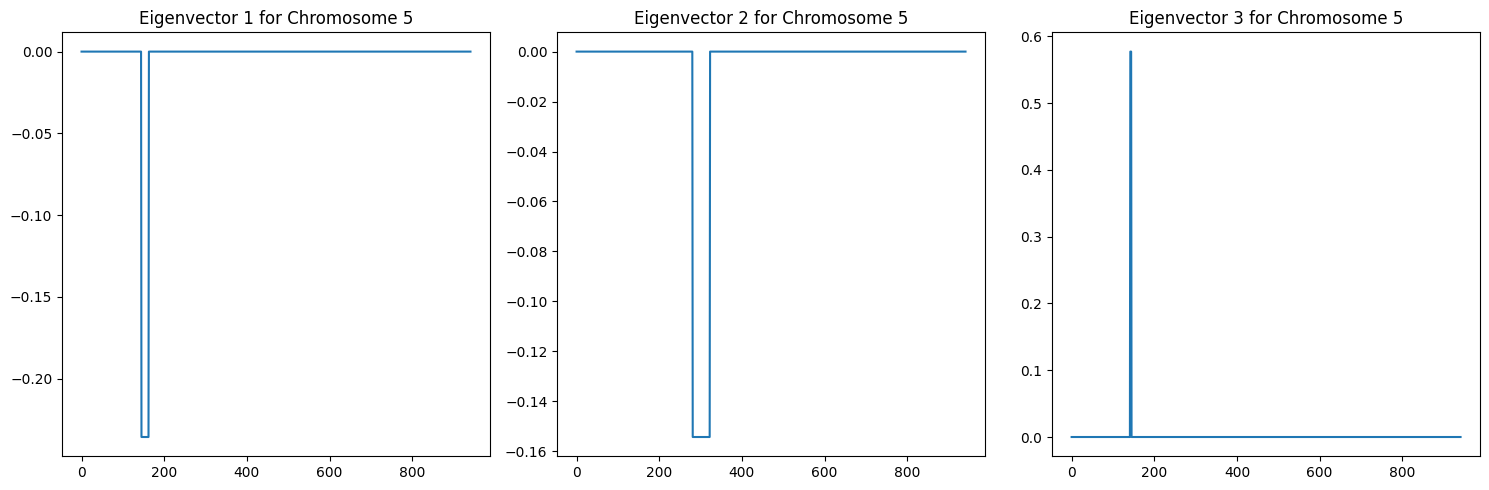

Error: smallest eigenvalue of the Laplacian is not close to zero


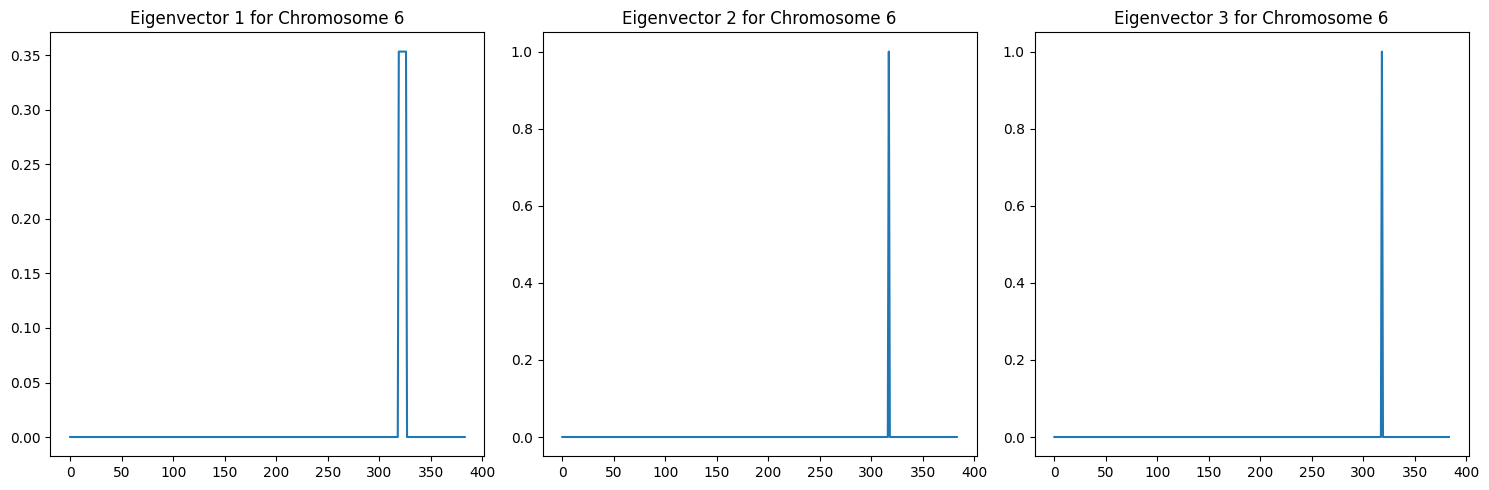

Error: smallest eigenvalue of the Laplacian is not close to zero


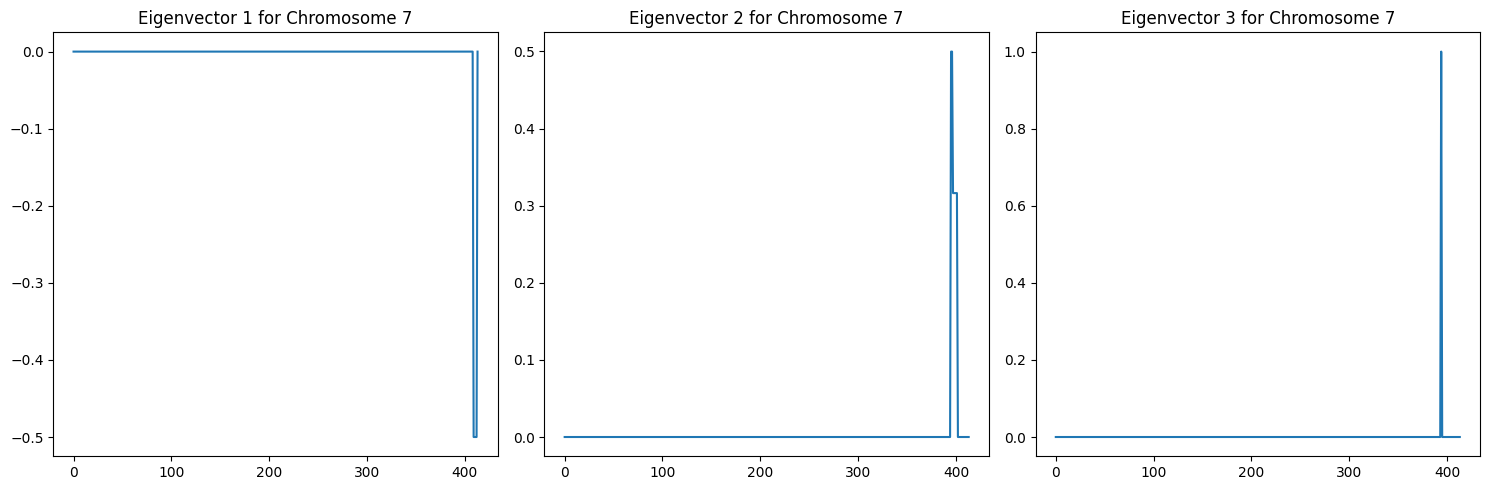

Error: smallest eigenvalue of the Laplacian is not close to zero


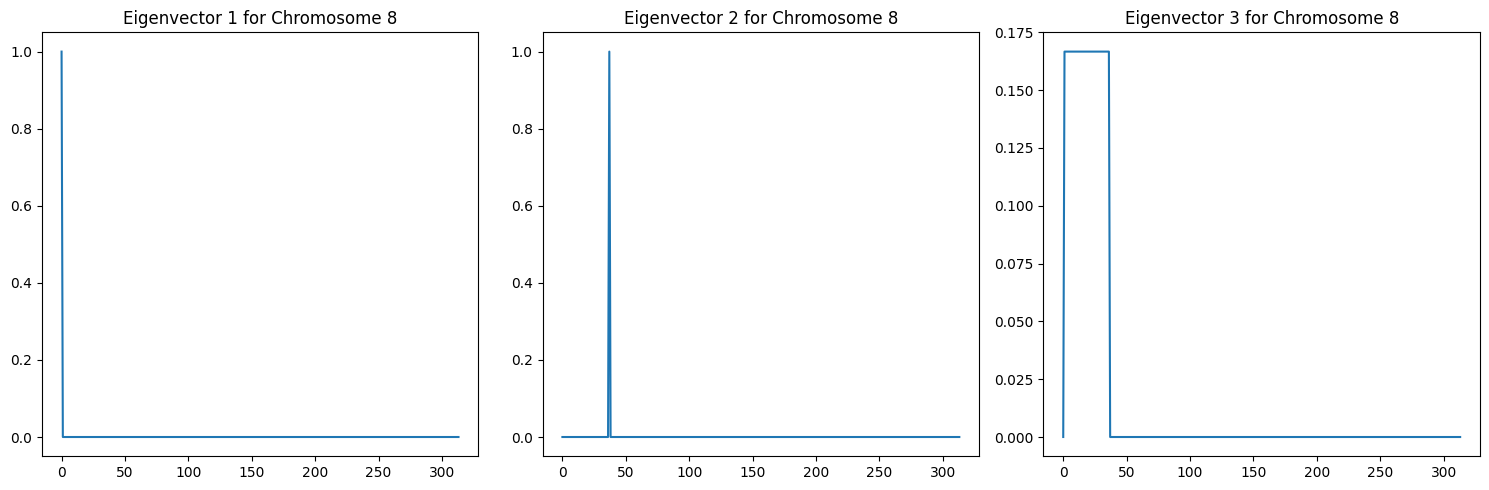

Error: smallest eigenvalue of the Laplacian is not close to zero


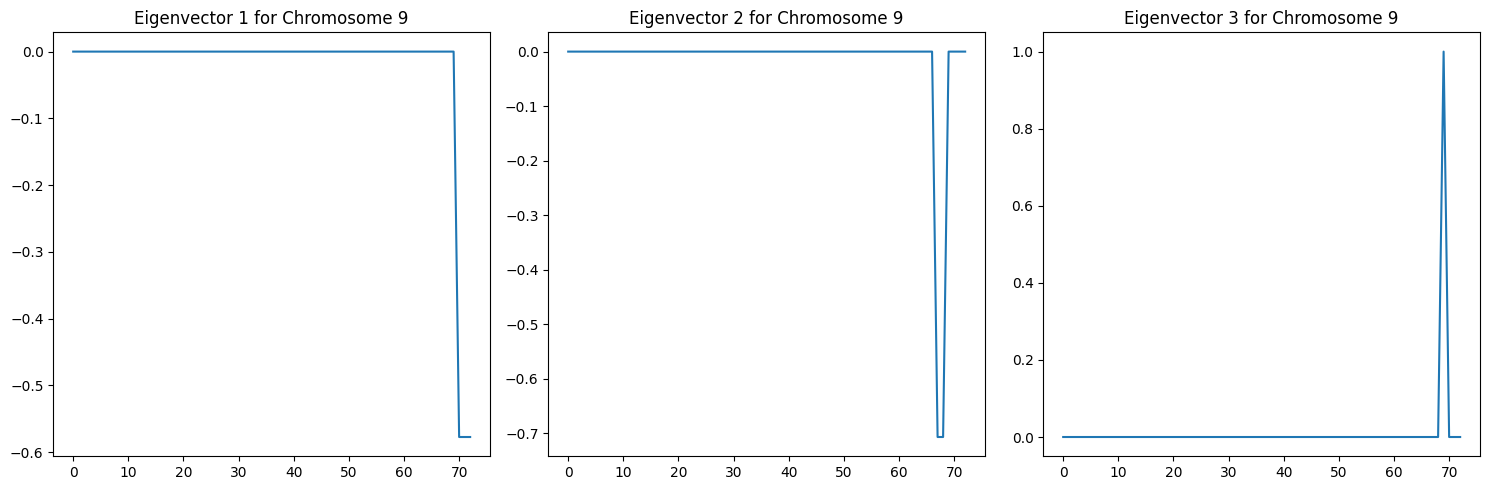

Error: smallest eigenvalue of the Laplacian is not close to zero


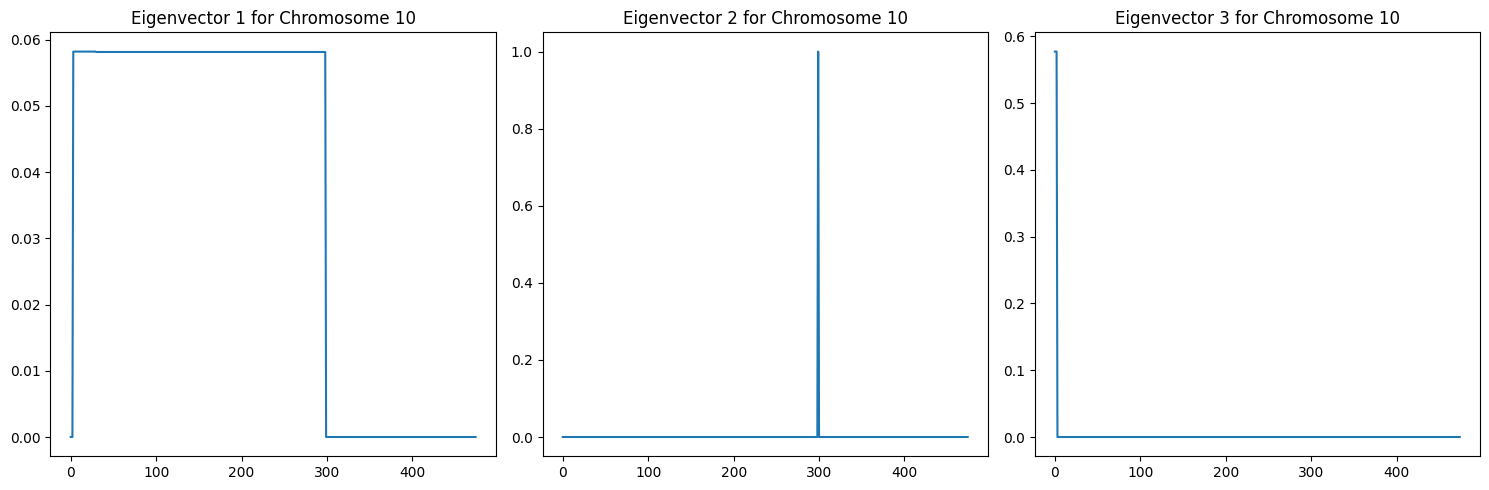

Error: smallest eigenvalue of the Laplacian is not close to zero


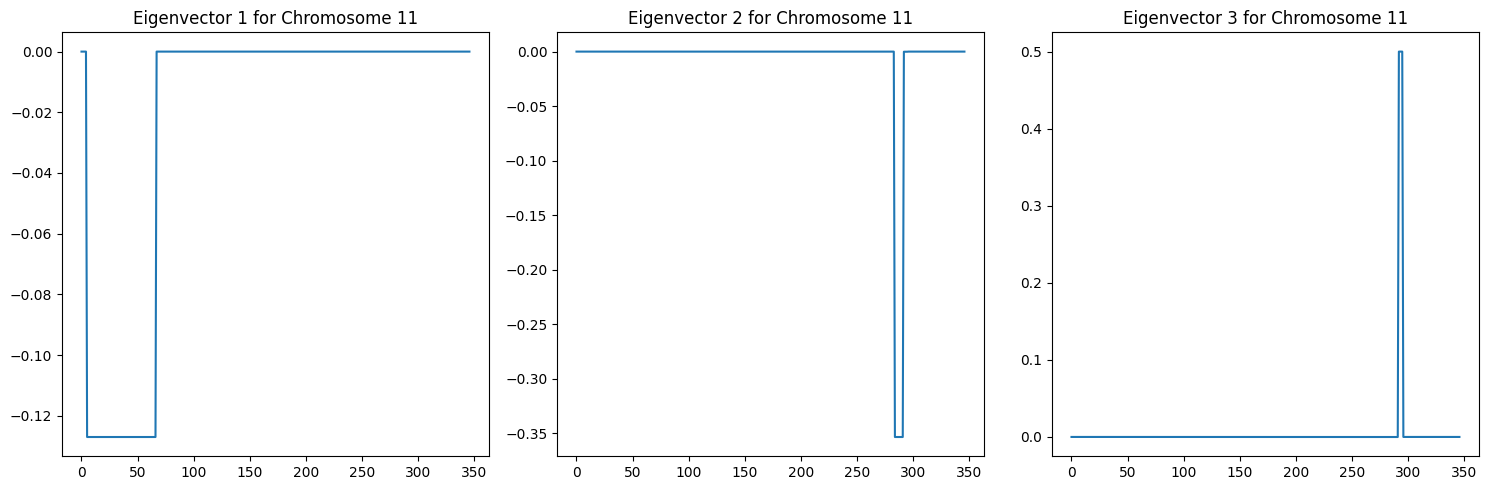

Error: smallest eigenvalue of the Laplacian is not close to zero


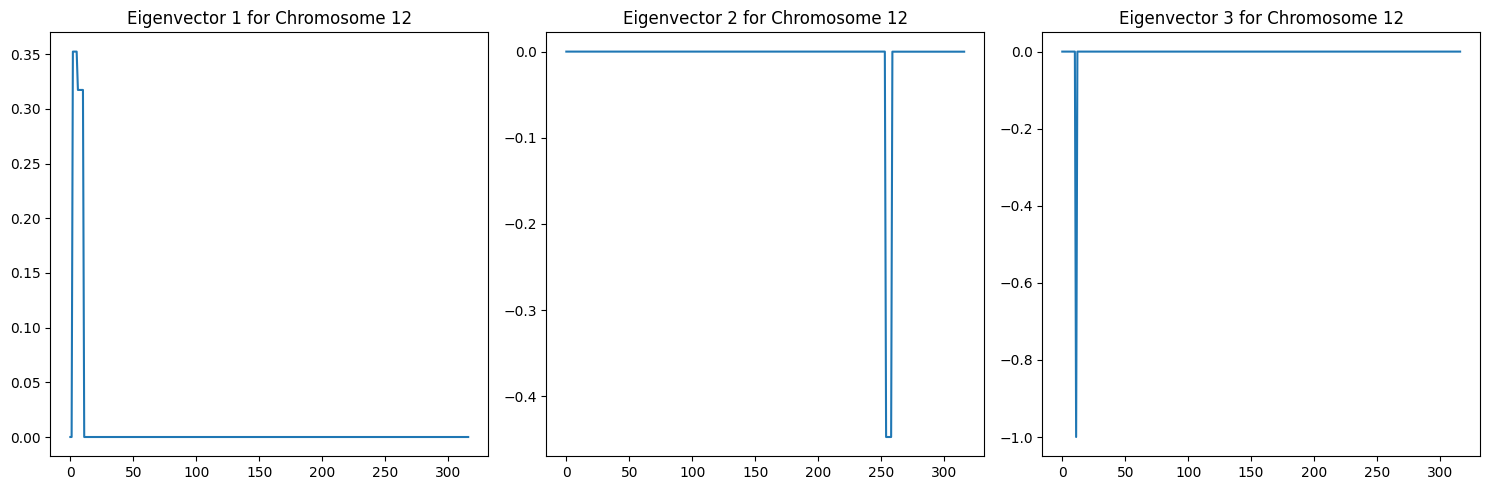

Error: smallest eigenvalue of the Laplacian is not close to zero


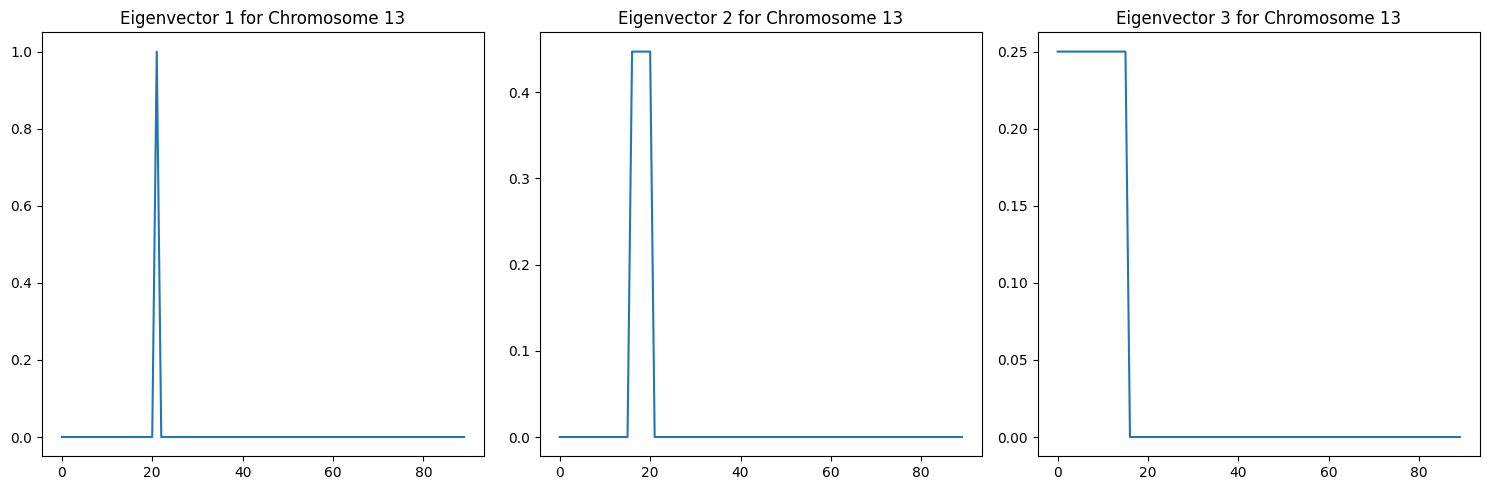

Error: smallest eigenvalue of the Laplacian is not close to zero


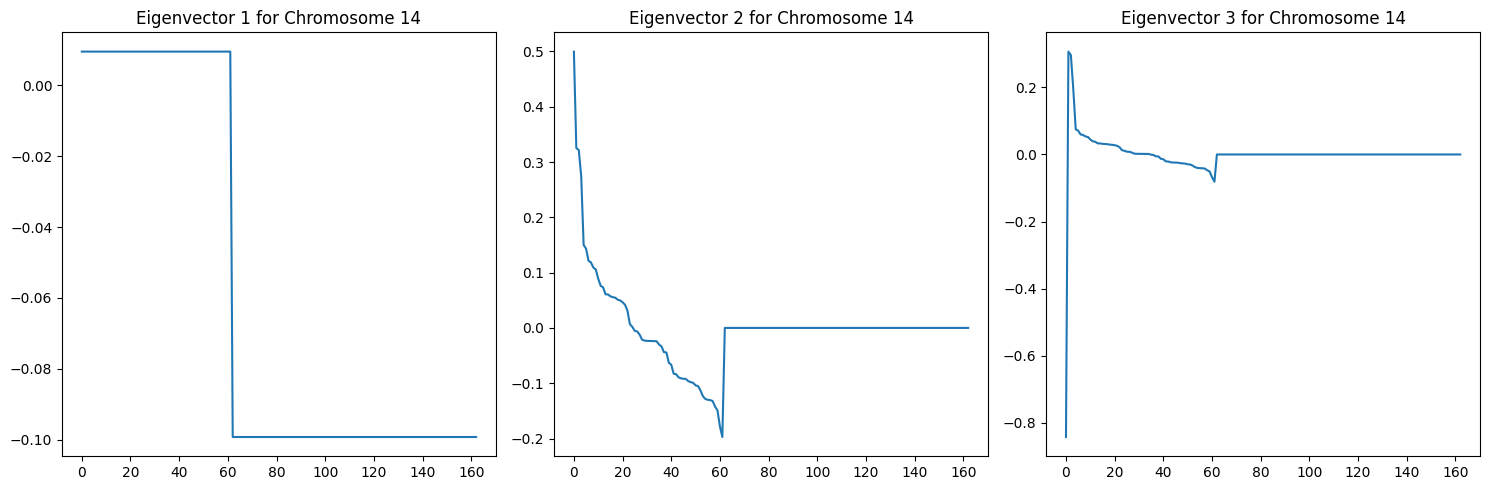

Error: smallest eigenvalue of the Laplacian is not close to zero


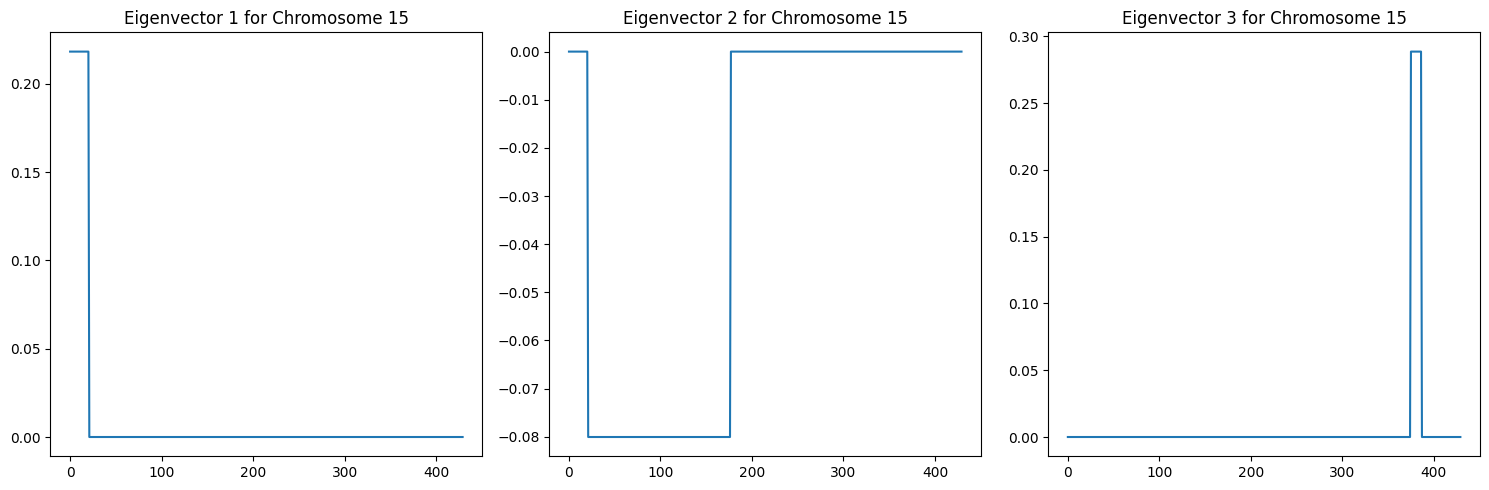

Error: smallest eigenvalue of the Laplacian is not close to zero


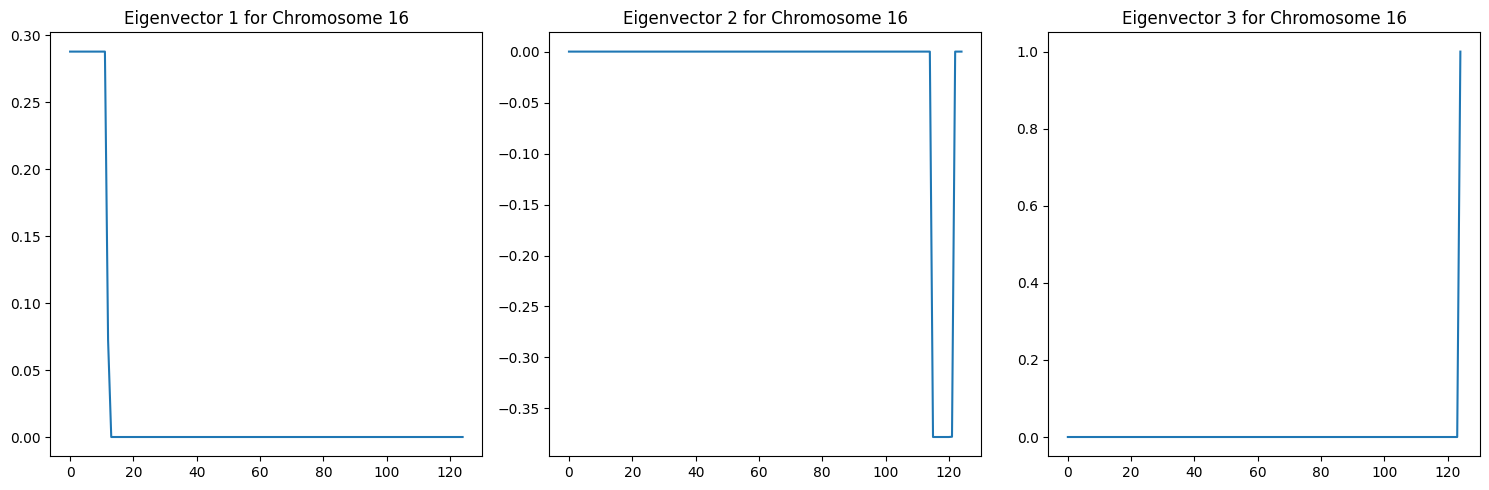

Error: smallest eigenvalue of the Laplacian is not close to zero


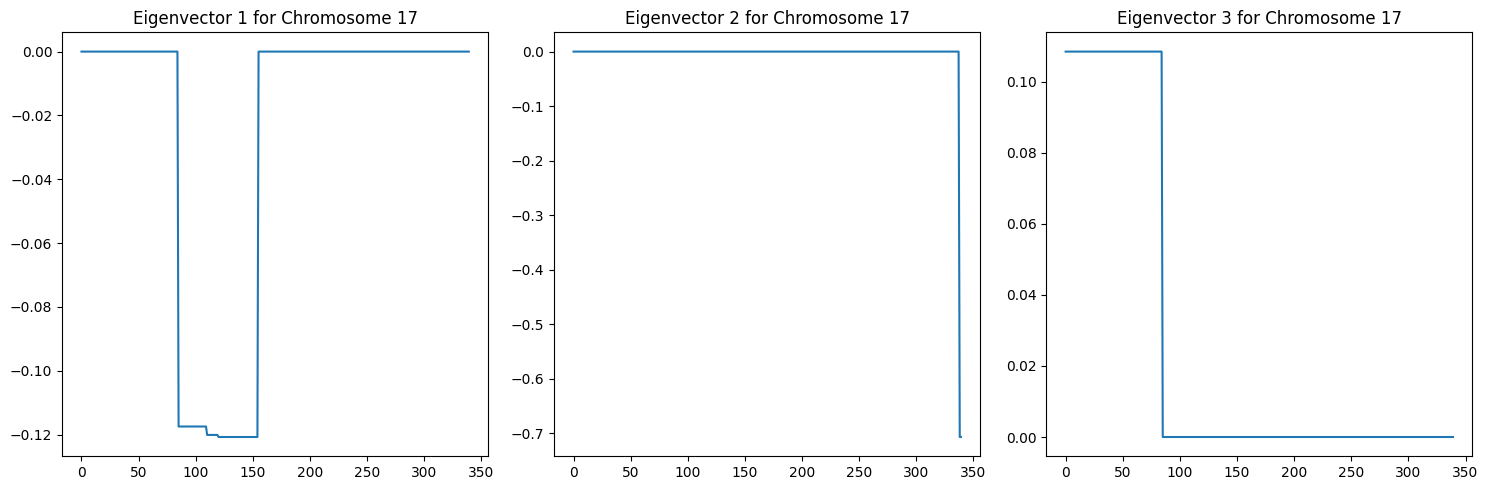

Error: smallest eigenvalue of the Laplacian is not close to zero


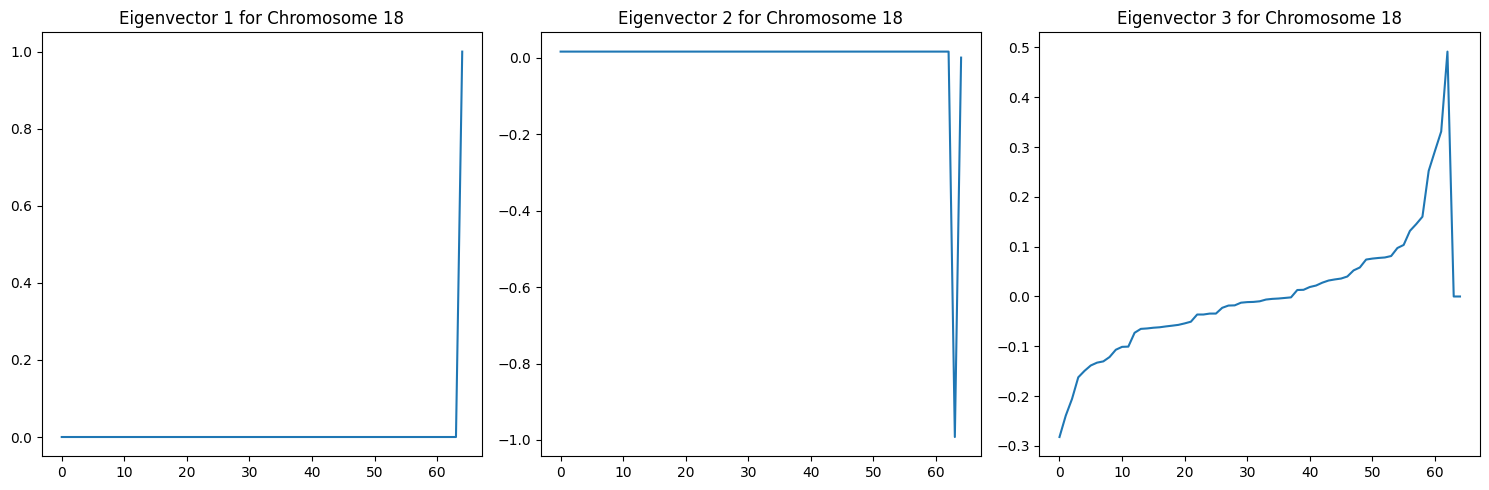

Error: smallest eigenvalue of the Laplacian is not close to zero


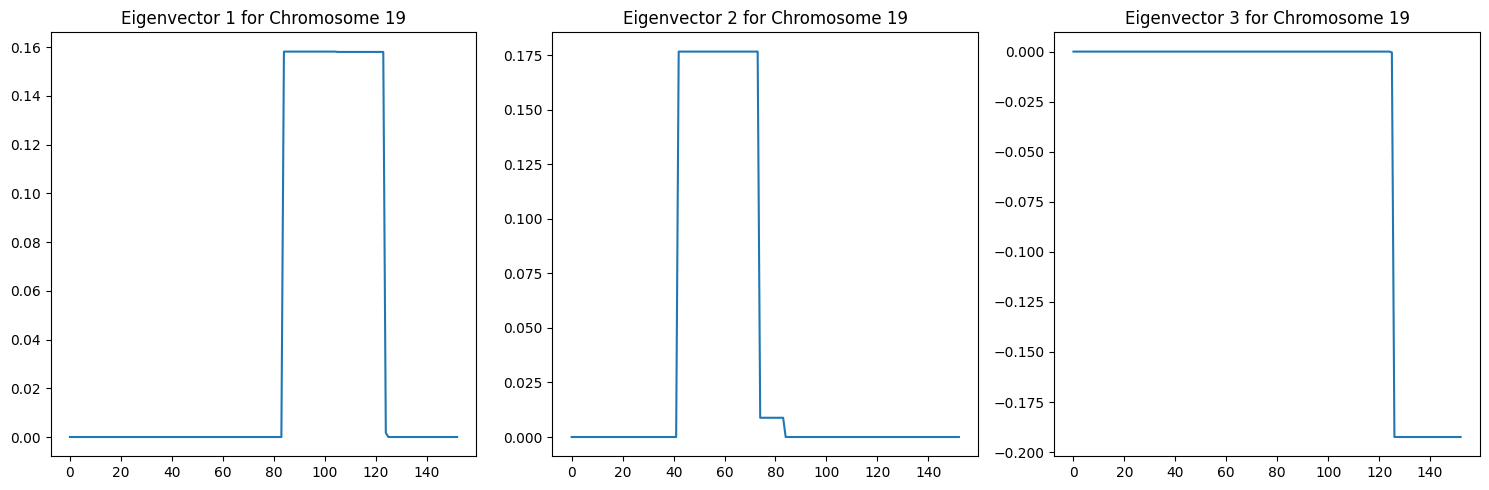

Error: smallest eigenvalue of the Laplacian is not close to zero


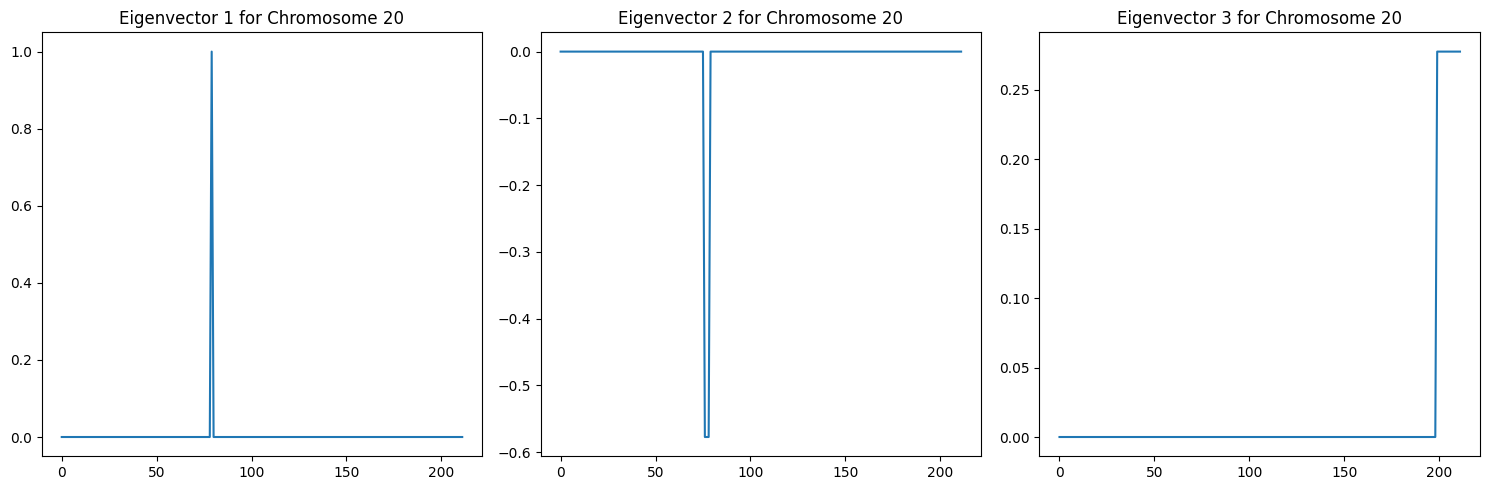

Error: smallest eigenvalue of the Laplacian is not close to zero


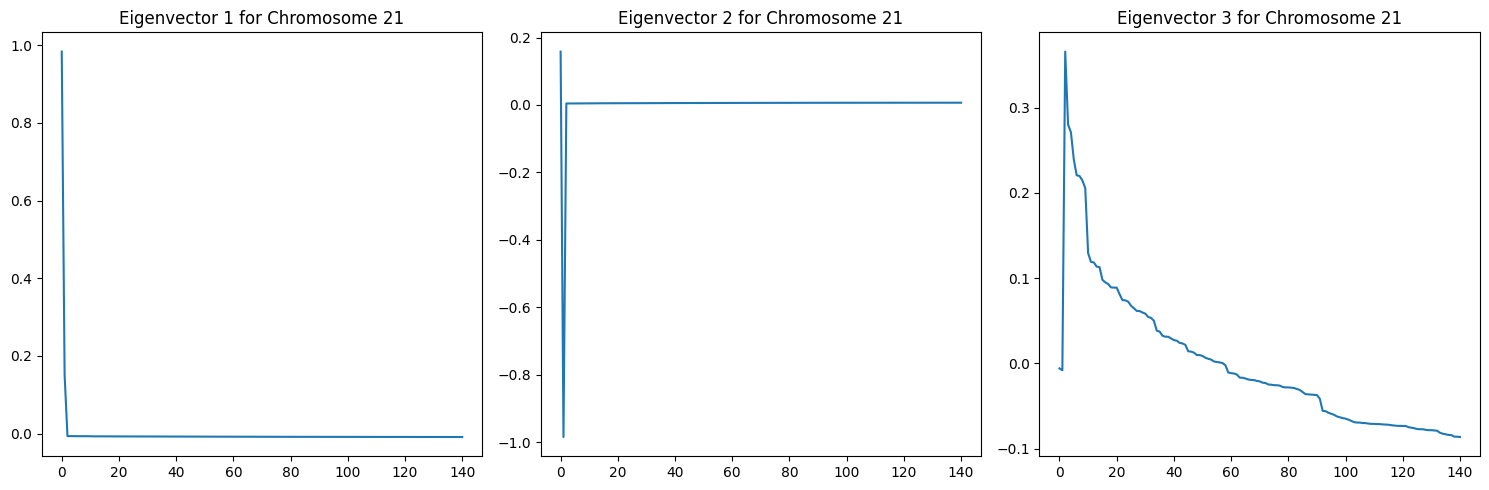

Error: smallest eigenvalue of the Laplacian is not close to zero


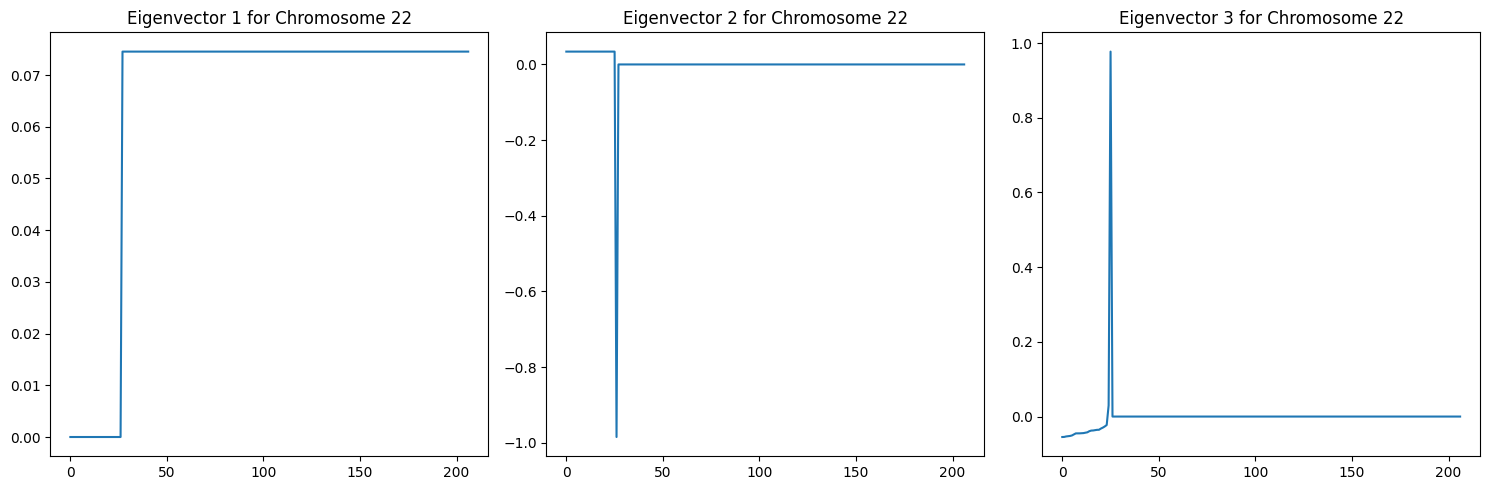

In [10]:
import pandas as pd
import numpy as np
from pygsp import graphs
from scipy.sparse import dok_matrix
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is a DataFrame that has been previously defined

# Initialize a dictionary to hold adjacency matrices for each chromosome
adjacency_dict = {}

# Iterate over each chromosome
for chromosome, group in data.groupby('#chrom'):
    # Initialize sparse adjacency matrix with zeros
    adjacency = dok_matrix((group.shape[0], group.shape[0]), dtype=np.float32)
    
    indices = group.index
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            # Calculate pos_diff_abs
            pos_diff_abs = abs(data.loc[indices[i], 'pos'] - data.loc[indices[j], 'pos'])
            
            # Calculate weight using given formula
            weight = 1 * np.exp(-np.log(2) / 100_000 * pos_diff_abs)
            
            # Update the adjacency matrix
            adjacency[i, j] = weight
            adjacency[j, i] = weight
            
    # Add the adjacency matrix to the dictionary with the chromosome as the key
    adjacency_dict[chromosome] = adjacency

# Create a color palette
color_palette = sns.color_palette('coolwarm', n_colors=len(data['precausal'].unique()))

# Create a dictionary mapping 'precausal' categories to colors
precausal_to_color = dict(zip(data['precausal'].unique(), color_palette))

# Map 'precausal' categories to colors
data['precausal_color'] = data['precausal'].map(precausal_to_color)

# Generate graph and plot eigenvectors for each chromosome
for chromosome, adjacency in adjacency_dict.items():
    # Create the graph using the adjacency matrix
    G = graphs.Graph(adjacency.tocsr())
    
    # Create the graph using the adjacency matrix
    G = graphs.Graph(adjacency.tocsr() + adjacency.tocsr().T)

    # Check for disconnected nodes
    if np.any(np.sum(G.W, axis=0) == 0):
        print("Warning: the graph has disconnected nodes")

    # Compute the Fourier basis of the graph
    try:
        G.compute_fourier_basis()
    except AssertionError:
        print("Error: smallest eigenvalue of the Laplacian is not close to zero")

    # Get the first three eigenvectors
    eigenvectors = G.U[:, 1:4]

    # Plot the first three eigenvectors
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axes):
        sns.lineplot(data=eigenvectors[:, i], ax=ax)
        ax.set_title(f'Eigenvector {i+1} for Chromosome {chromosome}')

    plt.tight_layout()
    plt.show()

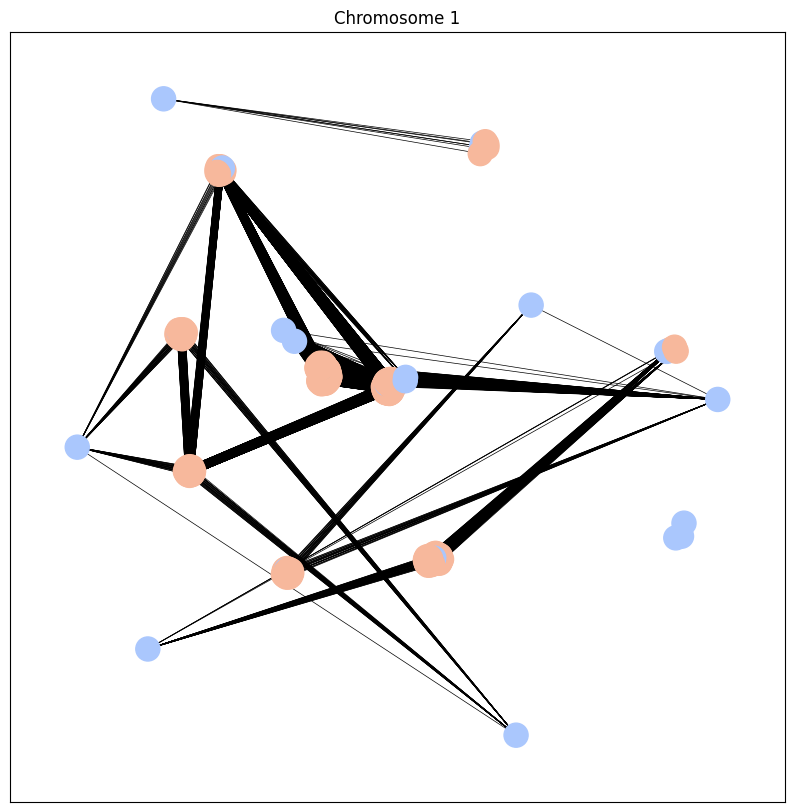

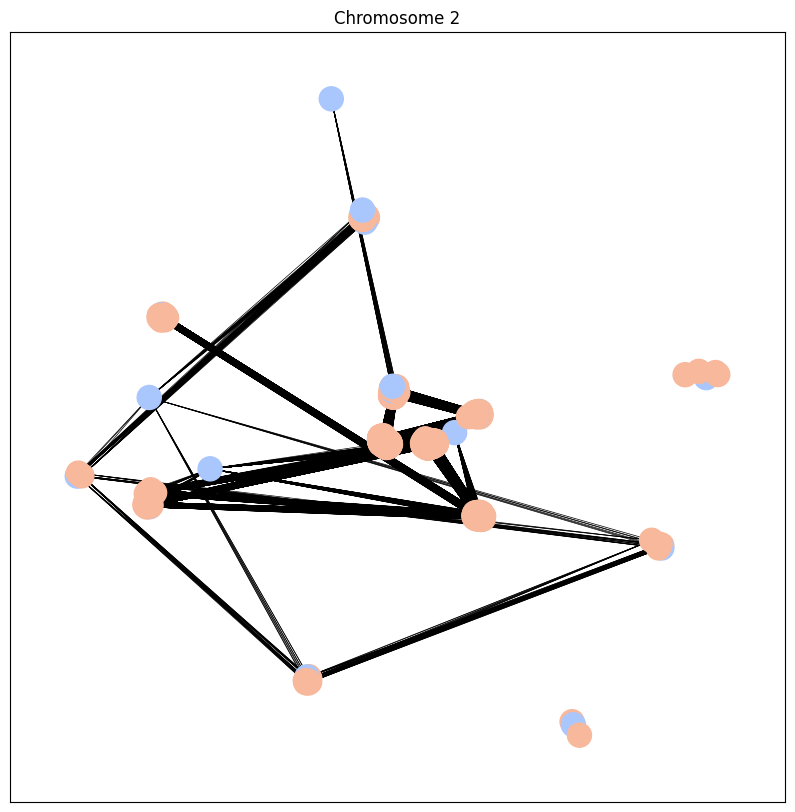

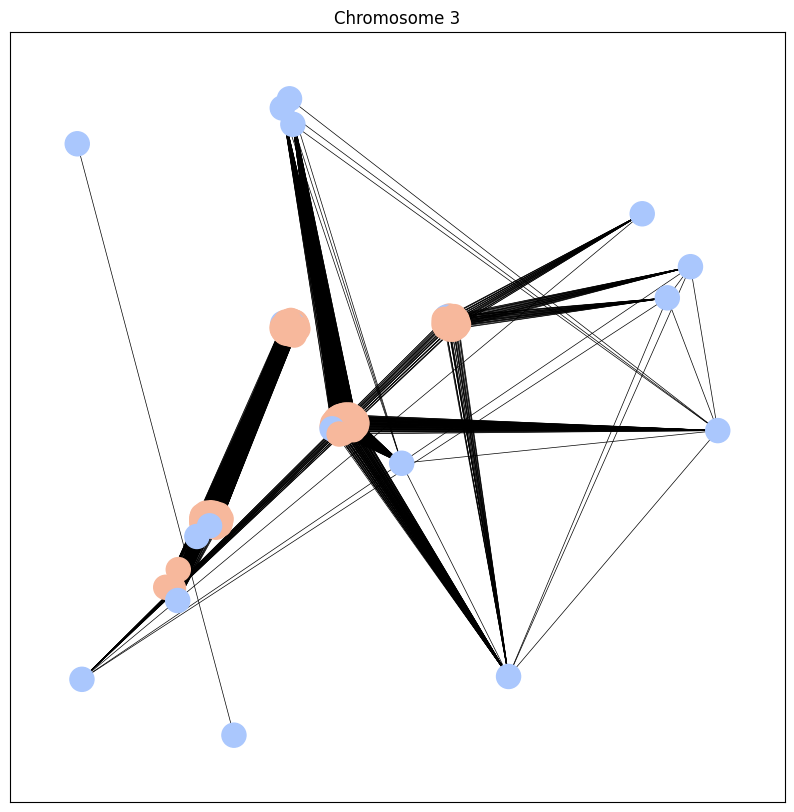

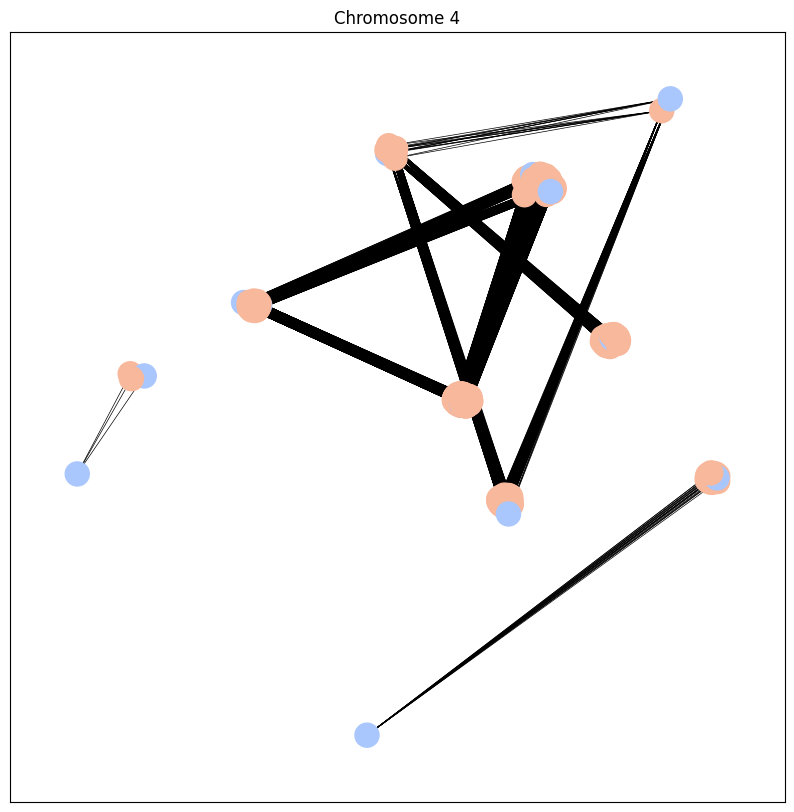

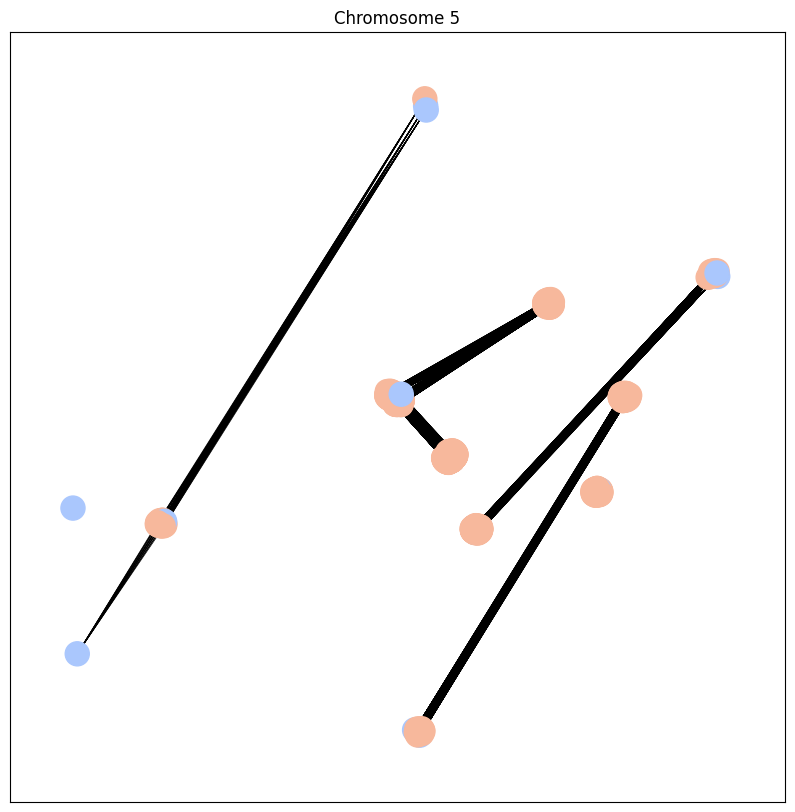

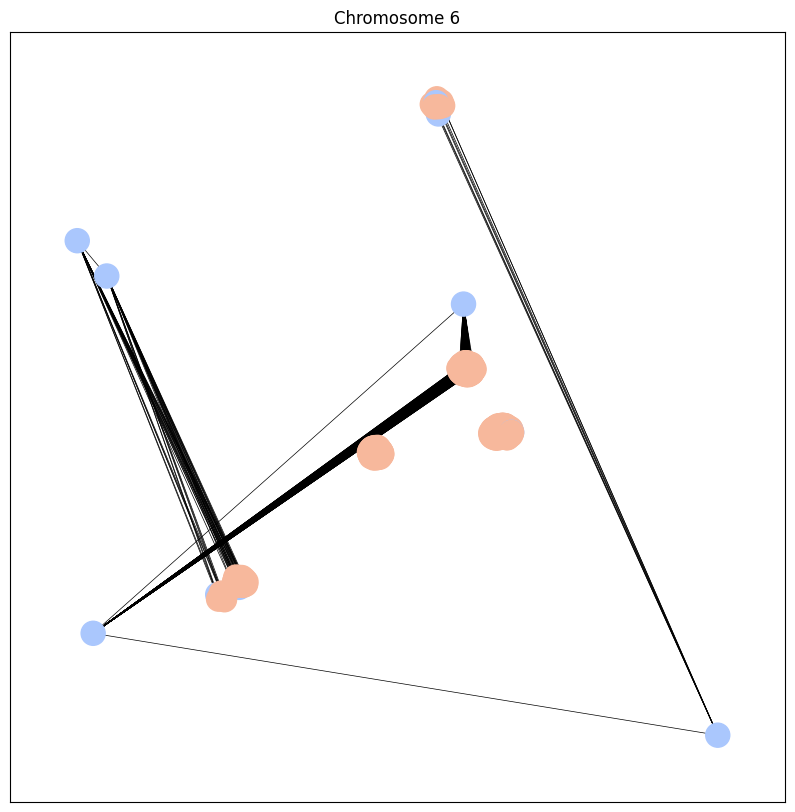

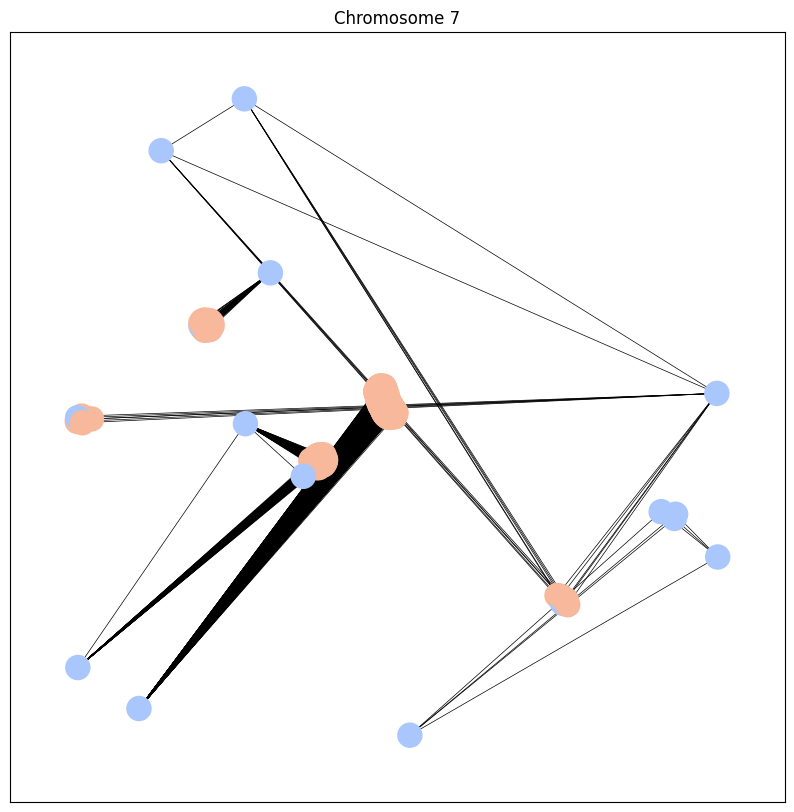

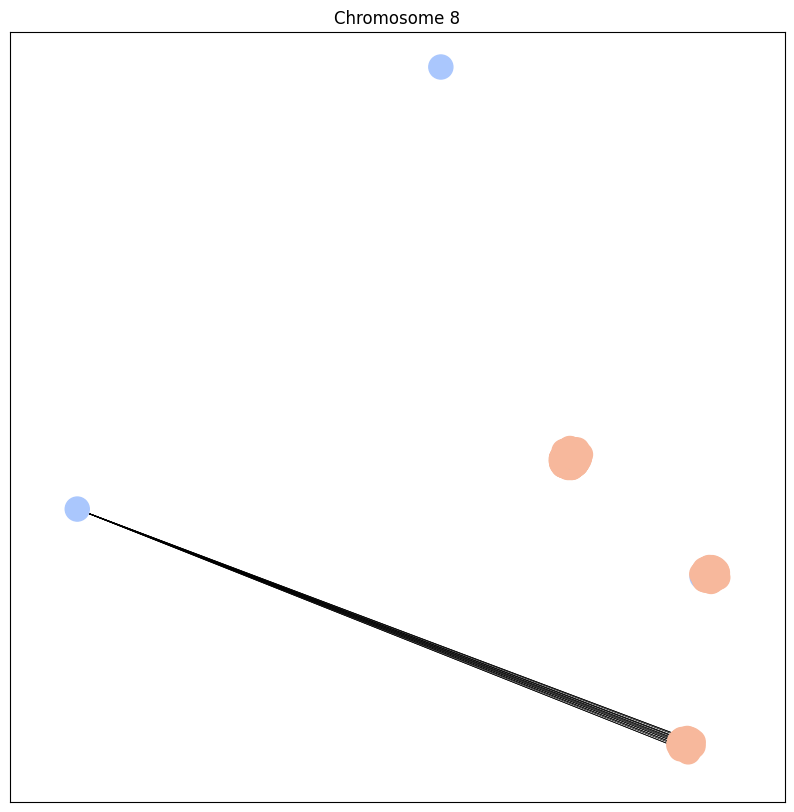

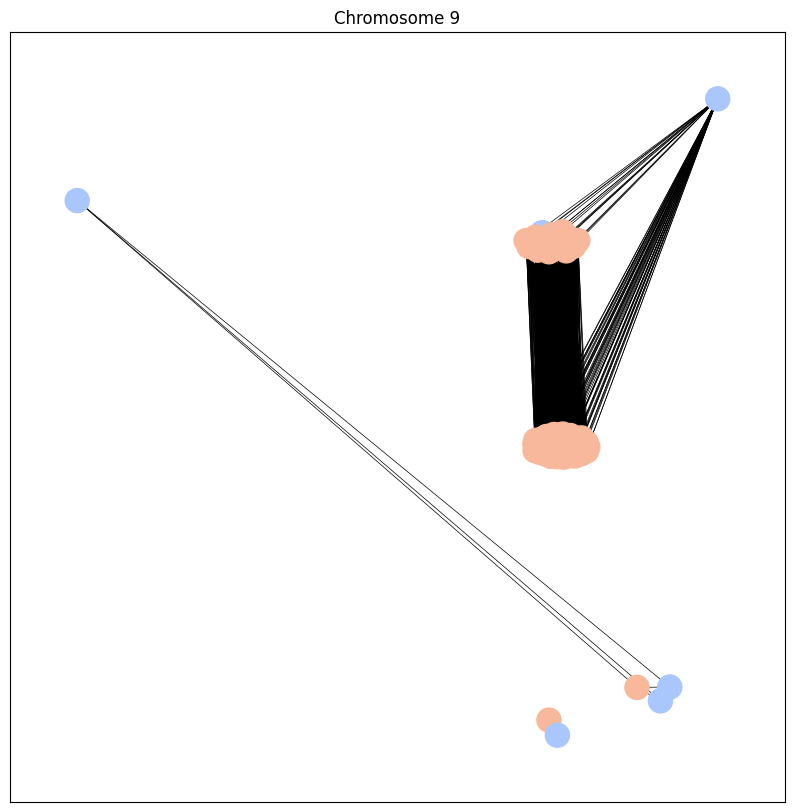

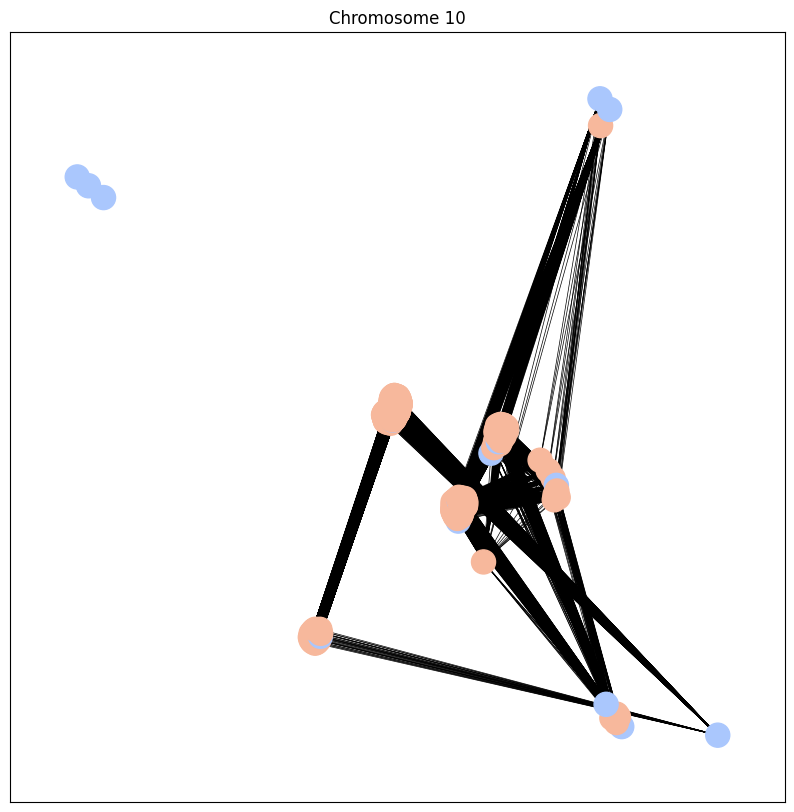

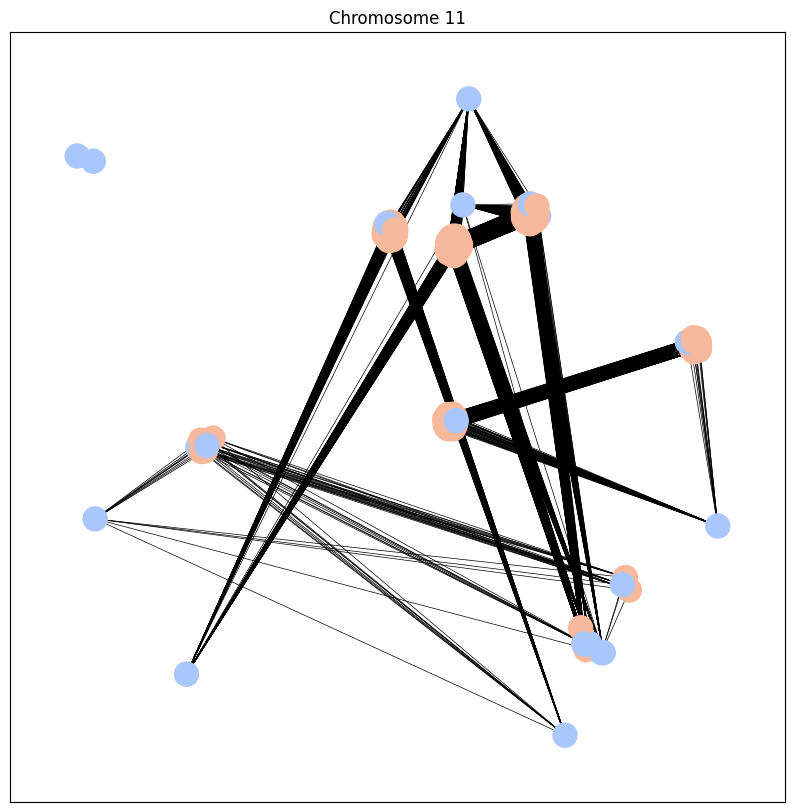

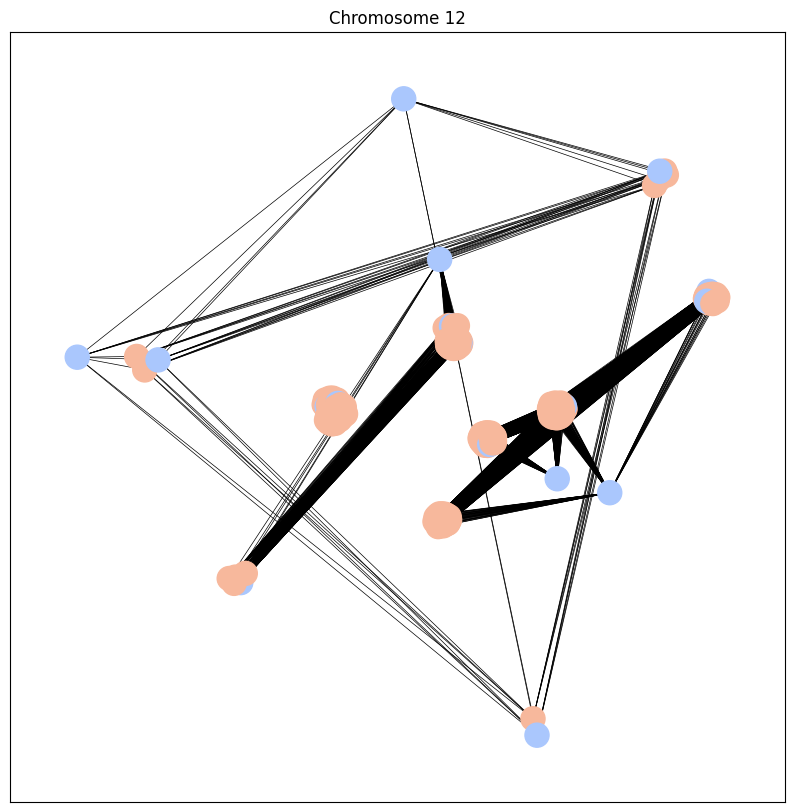

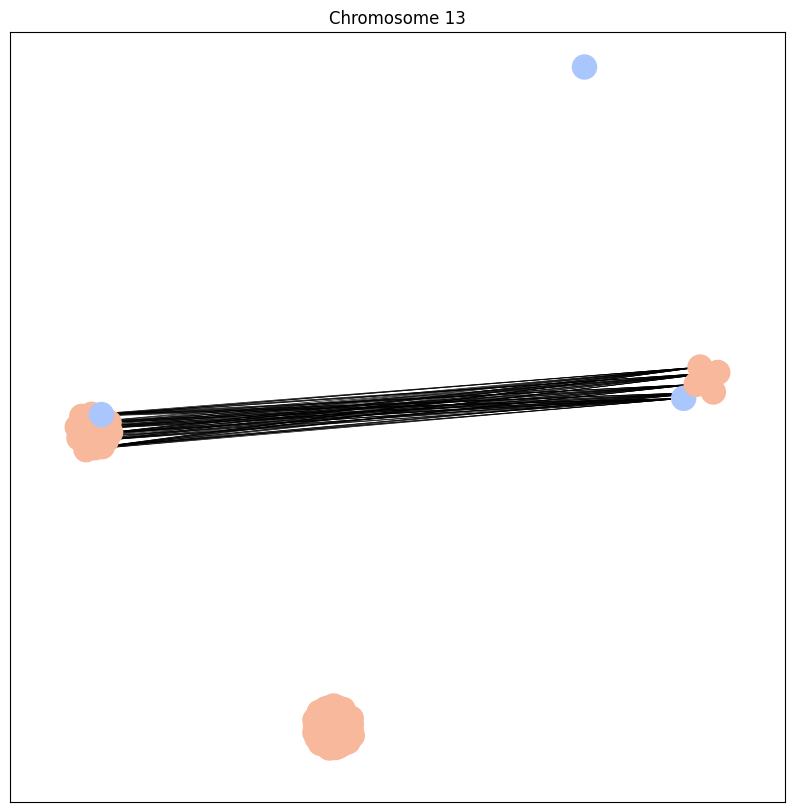

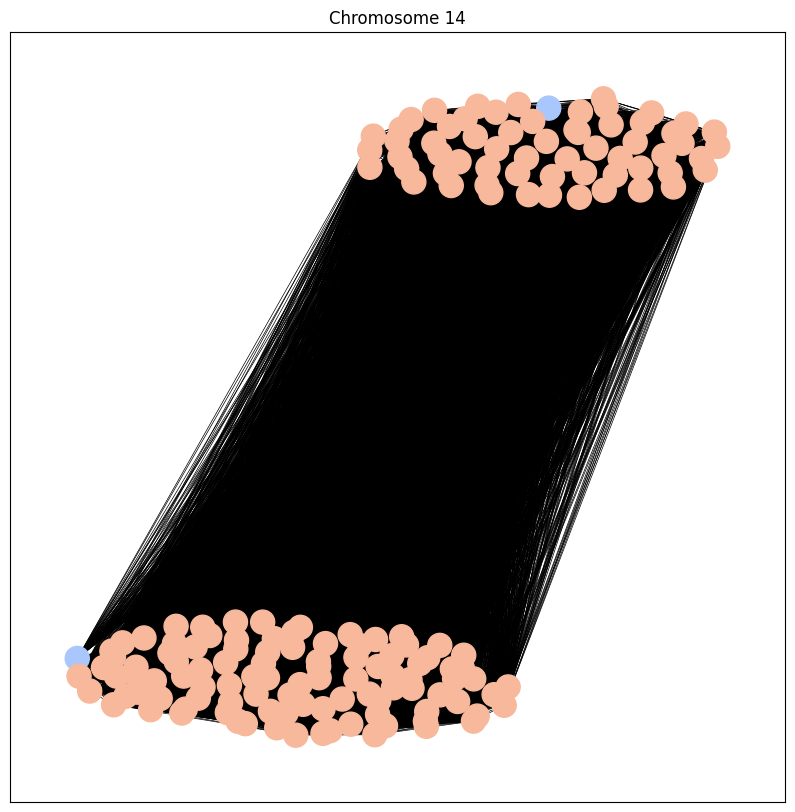

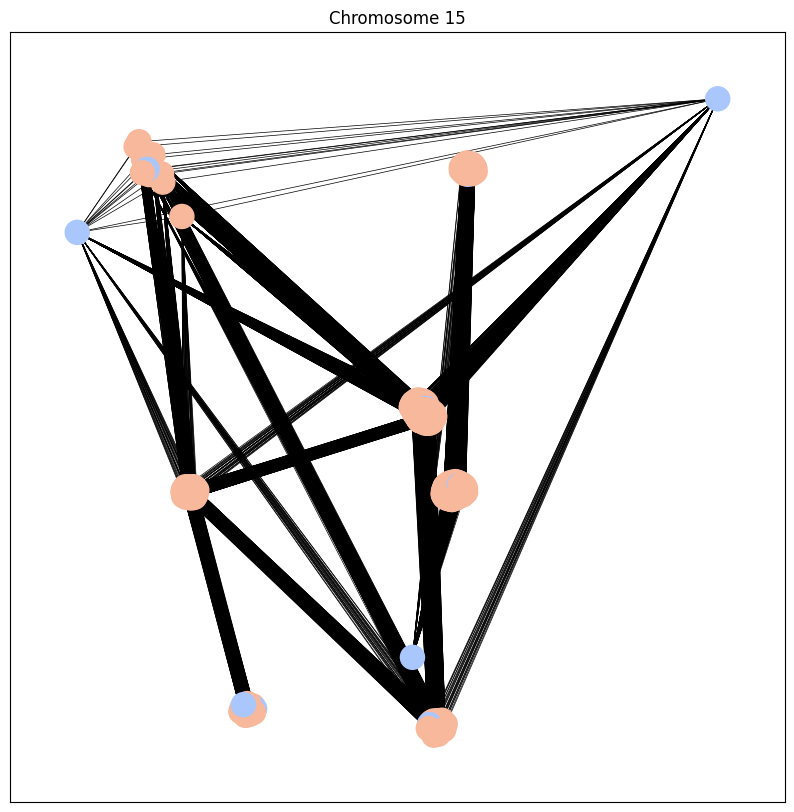

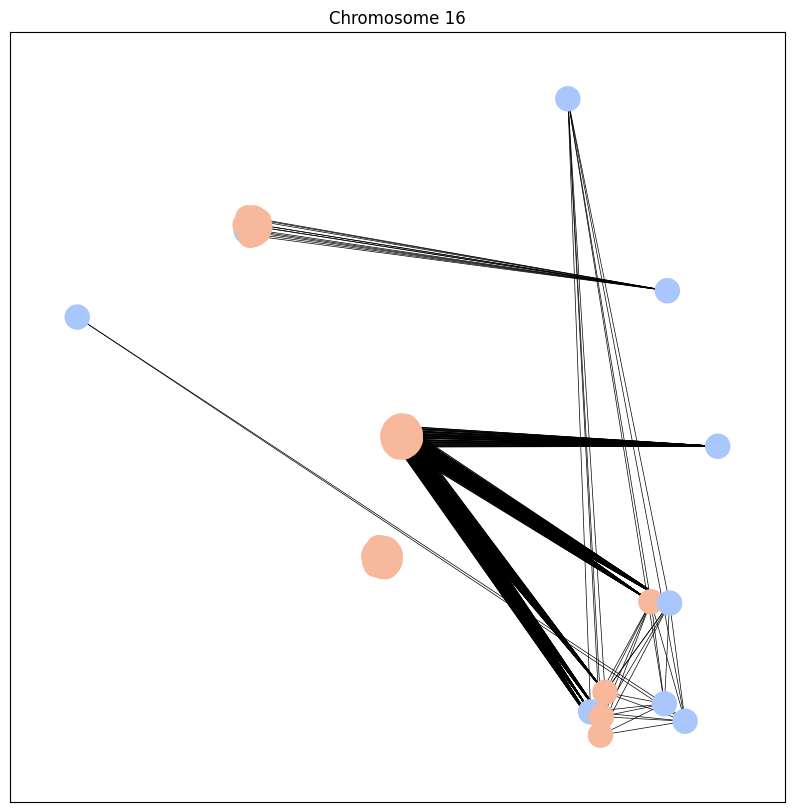

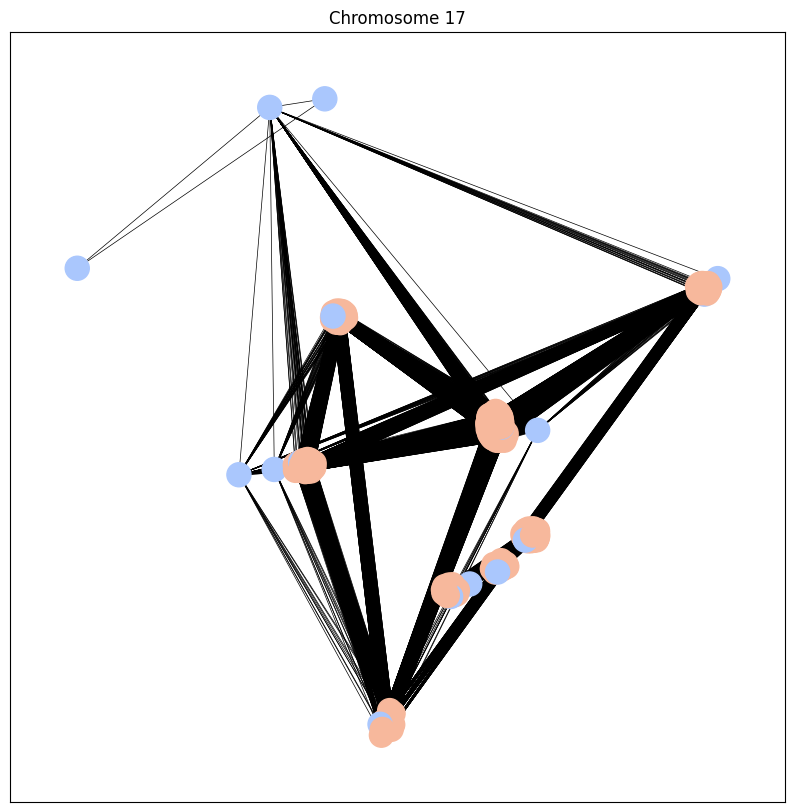

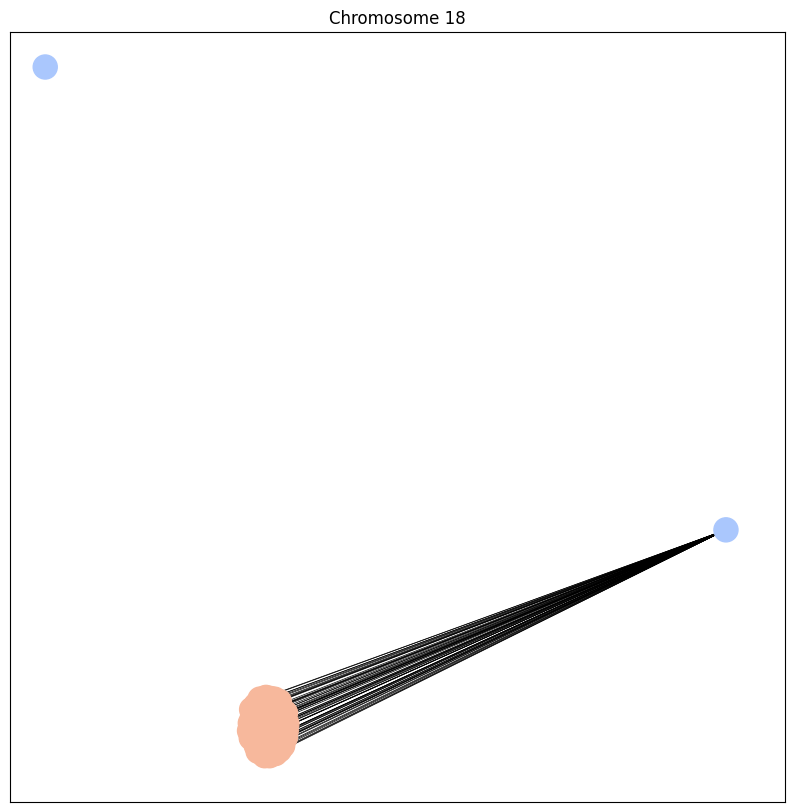

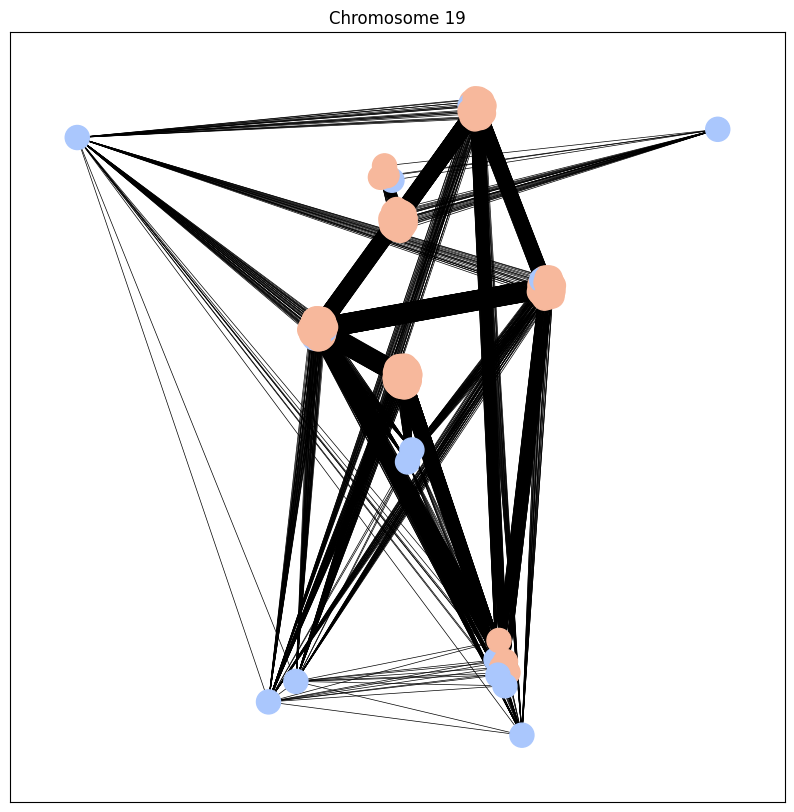

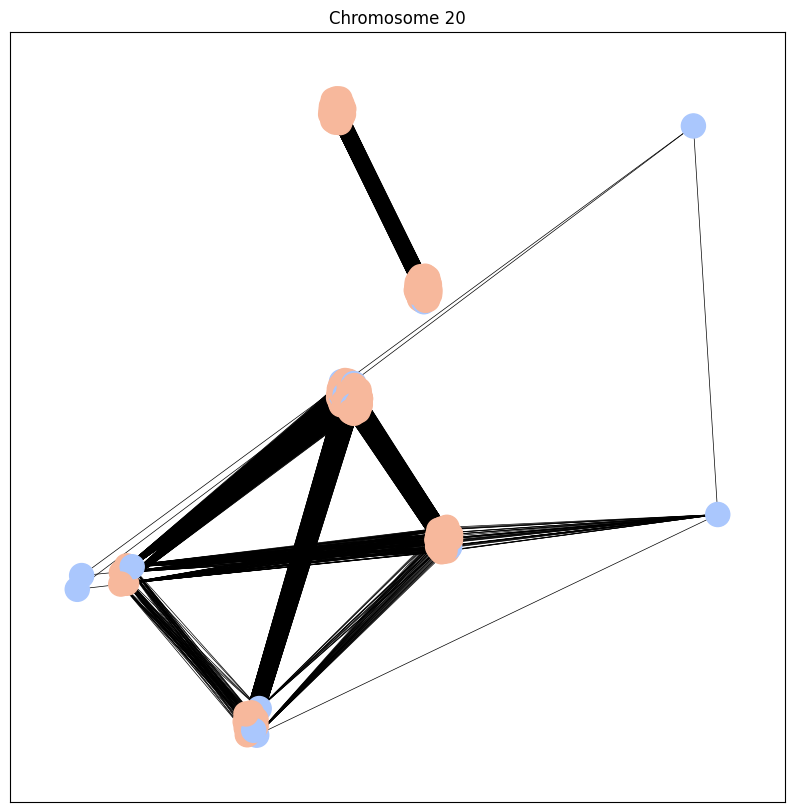

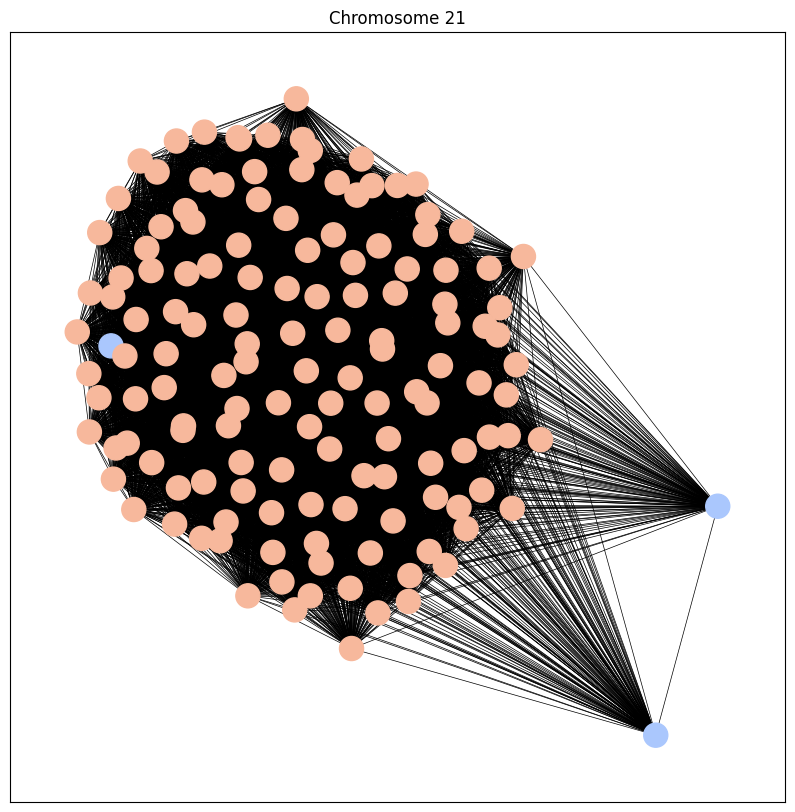

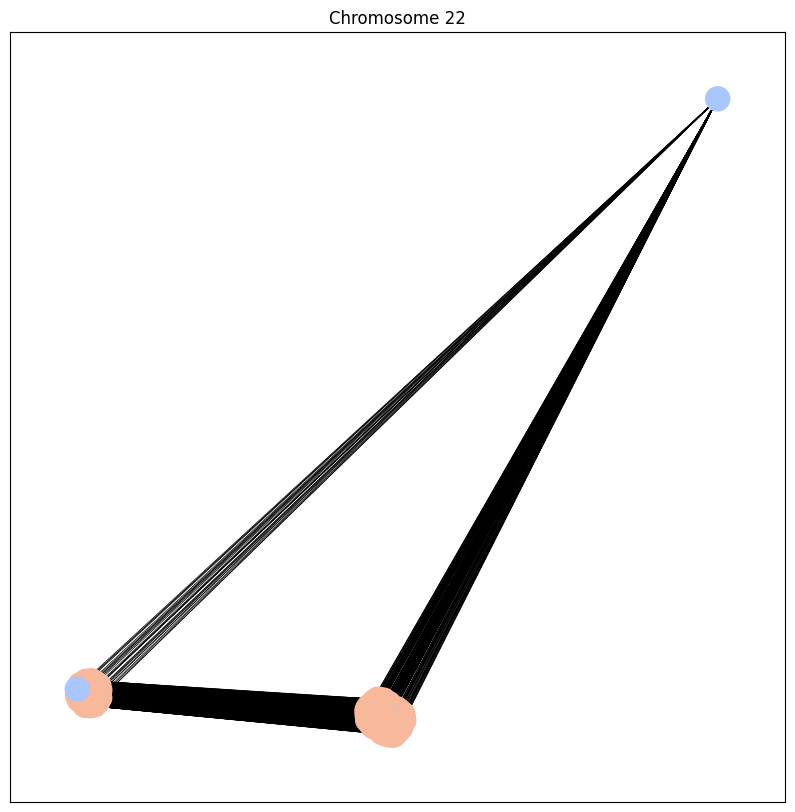

In [11]:
import pandas as pd
import numpy as np
from pygsp import graphs
from scipy.sparse import dok_matrix
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is a DataFrame that has been previously defined

# Initialize a dictionary to hold adjacency matrices for each chromosome
adjacency_dict = {}

# Iterate over each chromosome
for chromosome, group in data.groupby('#chrom'):
    # Initialize sparse adjacency matrix with zeros
    adjacency = dok_matrix((group.shape[0], group.shape[0]), dtype=np.float32)  # Adjust the adjacency matrix size to the group size
    
    indices = group.index
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            # Calculate pos_diff_abs
            pos_diff_abs = abs(data.loc[indices[i], 'pos'] - data.loc[indices[j], 'pos'])
            
            # Calculate weight using given formula
            weight = 1 * np.exp(-np.log(2) / 100_000 * pos_diff_abs)
            
            # Update the adjacency matrix
            adjacency[i, j] = weight  # Update indices in adjacency to i, j
            adjacency[j, i] = weight  # Update indices in adjacency to j, i
            
    # Add the adjacency matrix to the dictionary with the chromosome as the key
    adjacency_dict[chromosome] = adjacency

# Create a color palette
color_palette = sns.color_palette('coolwarm', n_colors=len(data['precausal'].unique()))

# Create a dictionary mapping 'precausal' categories to colors
precausal_to_color = dict(zip(data['precausal'].unique(), color_palette))

# Map 'precausal' categories to colors
data['precausal_color'] = data['precausal'].map(precausal_to_color)

# Generate and plot graph for each chromosome
for chromosome, adjacency in adjacency_dict.items():
    # Create the graph using the adjacency matrix
    G = graphs.Graph(adjacency.tocsr())
    
    # Convert the pygsp graph to a networkx graph
    G_nx = nx.from_scipy_sparse_array(G.W.tocsr())

    # Subset data for this chromosome
    chrom_data = data[data['#chrom'] == chromosome]

    # Add the node colors to the networkx graph
    for node, color in enumerate(chrom_data['precausal_color']):
        G_nx.nodes[node]['color'] = color

    # Draw the graph
    plt.figure(figsize=(10,10))
    plt.title(f'Chromosome {chromosome}')  # Add title for each plot
    nx.draw_networkx(G_nx, 
                     with_labels=False, 
                     node_color=[node[1]['color'] for node in G_nx.nodes(data=True)], 
                     edge_color='black',  
                     width=0.5)  
    plt.show()


## Plotting

## Umap

In [ ]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from category_encoders import BinaryEncoder

# Store 'precausal' for later use and remove from data
precausal = data['precausal']

# Binary encode 'nearest_genes'
encoder = BinaryEncoder(cols=['nearest_genes'])
data = encoder.fit_transform(data)

# Select the desired columns for UMAP
cols_to_keep = ['pos', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls']
cols_to_keep += [col for col in data.columns if 'nearest_genes' in col]  # keep encoded 'nearest_genes' columns
data = data[cols_to_keep]

# Use RobustScaler to normalize the columns
scaler = RobustScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Prepare data for UMAP
data_array = data.values

# Apply UMAP
reducer = umap.UMAP(random_state=seed)
embedding = reducer.fit_transform(data_array)

# Prepare DataFrame for Seaborn
umap_data = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_data['precausal'] = precausal.values  # make sure to use .values to match length

# Define palette for Seaborn
palette = {0: 'blue', 1: 'red'}

# Plot UMAP results, colored by 'precausal' using Seaborn
plt.figure(figsize=(25, 25))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='precausal', palette=palette, data=umap_data)
plt.title('UMAP projection of the dataset', fontsize=24)
plt.show()

In [ ]:
import scipy.spatial

# Separate the UMAP results into two groups
umap_data_0 = umap_data[umap_data['precausal'] == 0][['UMAP1', 'UMAP2']]
umap_data_1 = umap_data[umap_data['precausal'] == 1][['UMAP1', 'UMAP2']]

# Calculate the pairwise distances between the two groups
distances = scipy.spatial.distance.cdist(umap_data_1, umap_data_0, metric='euclidean')

# Calculate the average distance
average_distance = np.median(distances)

print(f"The average distance between precausal=1 points and precausal=0 points is {average_distance}")

In [ ]:
import scipy.spatial

# Select UMAP results where `precausal=1`
umap_data_1 = umap_data[umap_data['precausal'] == 1][['UMAP1', 'UMAP2']]

# Calculate the pairwise distances within the group
distances = scipy.spatial.distance.pdist(umap_data_1, metric='euclidean')

# Calculate the average distance
average_distance = np.median(distances)

print(f"The average distance between precausal=1 points is {average_distance}")


In [ ]:
import scipy.spatial

# Select UMAP results where `precausal=0`
umap_data_0 = umap_data[umap_data['precausal'] == 0][['UMAP1', 'UMAP2']]

# Calculate the pairwise distances within the group
distances = scipy.spatial.distance.pdist(umap_data_0, metric='euclidean')

# Calculate the average distance
average_distance = np.median(distances)

print(f"The average distance between precausal=0 points is {average_distance}")
